# Centroid based Tracking
The idea for this tracking method is to track a specific object using the centroid of the objects detected in a frame, and comparing them with the ones detected in the previous frame.
- **Step #1**: Accept bounding box coordinates and compute centroids
- **Step #2**: Compute Euclidean distance between new bounding boxes and existing objects
- **Step #3**: Update (x, y)-coordinates of existing objects
---

The first thing we are going to test is to extract the objects of a frame based on the countours.

The steps to follow are the ones bellow:
1. Convert image to HSV
2. Threshold on red to segment the rectangle
3. Apply some morphology to close the contour as much as possible
4. Detect external contours
5. Filter noisy blobs based on area; You are looking for the largest contour
6. Get the contour's bounding rectangle
7. Slice the image using the bounding rectangle

In [3]:
def getBoundingBoxes(file_path = "./datasets/MotorcycleChase/groundtruth_rect.txt"):
    boundingBoxes = {}
    with open(file_path,'r') as file:
        for line in file:
            l = line.split(',')
            id,x1,y1,width,height,visible = list(map(int,l))
            #bbox = patches.Rectangle((x1, y1), width, height, linewidth=1, edgecolor='red', facecolor='none')
            boundingBoxes[id] = (x1,y1,width,height)
    return boundingBoxes

In [4]:
def getCroppedBB(img, bb):
    img = img[bb[1]:bb[1]+bb[3],bb[0]:bb[0]+bb[2]]
    return cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

---

In [8]:
%matplotlib inline
#The line above is necesary to show Matplotlib's plots inside a Jupyter Notebook
import cv2
import matplotlib.pyplot as plt
import os
import matplotlib.patches as patches
from PIL import Image
import numpy as np
import sys
import time
import AuxFunctions

In [9]:
def computeCentroid(box):
    xCoord = box[0] - box[2]
    yCoord = box[1] - box[3]
    
    return (xCoord, yCoord)

In [10]:
def computeEuclideanDistance(p1,p2):
    vect = (p2[0] - p1[0], p2[1] - p1[1])
    return np.sqrt(vect[0]*vect[0] + vect[1]*vect[1])

---

In [13]:
def runTracker(mainDirectory = "./datasets/MotorcycleChase", maxFramesToShow = 1000, showEveryX=5):

    # get bounding boxes data
    filepathBB = os.path.join(mainDirectory, "groundtruth_rect.txt")
    try:
        bbs = AuxFunctions.getBoundingBoxes(filepathBB)
    except:
        print("Haven't been found the groundtruth_rect.txt file")

    # analyze the first frame
    imgPath = os.path.join(mainDirectory, "img")
    frame0path = os.path.join(imgPath, "00001.jpg")
    firstFrame = cv2.imread(frame0path)

    bb = bbs[1]
    bbArea = (bb[2])*(bb[3])

        # save previous frame's box and centroid
    previousCentroid = computeCentroid(bb)
    previousBox = bb
    print(previousCentroid)

    firstFrameCopy = firstFrame.copy()
    cv2.rectangle(firstFrameCopy, (bb[0],bb[1]), (bb[0]+bb[2],bb[1]+bb[3]), (255,0,0), 3)
    
    #frames to show
    framesToShow = min(maxFramesToShow, len(os.listdir(imgPath)))

    i = 0
    numFrame = 0
    for filename in os.listdir(imgPath)[2:framesToShow]:
        numFrame +=1
        # reading the frame
        filepath = os.path.join(imgPath, filename)   
        frame = plt.imread(filepath)
        frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)

        # array for boxes detected in the frame
        frameBoxes = []

        # detect objects in the frame ---------------------------
        blurred = cv2.GaussianBlur(frame, (5,5), 0)

        pixel_vals = blurred.reshape((blurred.shape[0]*blurred.shape[1],3))
        pixel_vals = np.float32(pixel_vals)

        criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 100, 0.2)

        k = 5
        retval, labels, centers = cv2.kmeans(pixel_vals, k, None, criteria, 10, cv2.KMEANS_RANDOM_CENTERS)

        centers = np.uint8(centers)
        segmented_data = centers[labels.flatten()]

        segmented_image = segmented_data.reshape((blurred.shape))
        labels_reshape = labels.reshape(frame.shape[0], blurred.shape[1])

        gray = cv2.cvtColor(segmented_image, cv2.COLOR_RGB2GRAY)

        thresh, result = cv2.threshold(gray, 0, 255, cv2.THRESH_OTSU)
        result = ~result
        kernel = np.ones((10,10), np.uint8)
        # Using cv2.erode() method 
        result = cv2.erode(result, kernel) 

        kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (13,13))
        result = cv2.morphologyEx(result, cv2.MORPH_CLOSE, kernel)

            # extract countours
        contours, hierarchy = cv2.findContours(image=result, mode=cv2.RETR_TREE, method=cv2.CHAIN_APPROX_NONE)
        ctrs = frame.copy()
        cv2.drawContours(image=ctrs, contours=contours, contourIdx=-1, color=(0, 255, 0), thickness=2, lineType=cv2.LINE_AA)

        frameRGB = frame.copy()
            # detect objects
        for _,c in enumerate(contours):
            blobArea = cv2.contourArea(c)
            if blobArea > bbArea*0.1 and blobArea < bbArea*1.9:
                boundingRect = cv2.boundingRect(c)

                offset = 2
                # Draw the rectangle on the input image
                # Get the dimensions of the bounding rect:
                rectX = int(boundingRect[0] + offset)
                rectY = int(boundingRect[1] + offset)
                rectWidth = int(boundingRect[2] - 2 * offset)
                rectHeight = int(boundingRect[3] - 2 * offset)

                blobBB = (rectX, rectY, rectWidth, rectHeight)

                # Box format: rectX, rectY, rectWidth, rectHeight
                frameBoxes.append((blobBB[0], blobBB[1], blobBB[2], blobBB[3]))
                #cv2.rectangle(frameRGB, (blobBB[0], blobBB[1]), (blobBB[0]+blobBB[2], blobBB[1]+blobBB[3]), (255,0,0), 3)

        # find the centroid with minimum euclidean distance, if some has been detected
        if len(frameBoxes) != 0:
            idx = -1
            it = 0

            minDistance = float("inf")

            for box in frameBoxes:
                centroid_i = computeCentroid(box)
                tmpDist = computeEuclideanDistance(previousCentroid, centroid_i)
                if tmpDist < minDistance:
                    minDistance = tmpDist
                    idx = it
                it += 1

                # update new centroid
            previousBox = frameBoxes[idx]
            previousCentroid = computeCentroid(previousBox)
            bbArea = (previousBox[2])*(previousBox[3])
            print("Using last frame")

            cv2.rectangle(frameRGB, (previousBox[0], previousBox[1]), (previousBox[0]+previousBox[2], previousBox[1]+previousBox[3]), (255,0,0), 3)

        # cv2.rectangle(frameRGB, (previousBox[0], previousBox[1]), (previousBox[0]+previousBox[2], previousBox[1]+previousBox[3]), (255,0,0), 3)
        if(numFrame%showEveryX == 0):
            fig,ax = plt.subplots()
            ax.imshow(frameRGB)
            plt.show() 
        numFrame+=1

(323, 234)
Using last frame
Using last frame
Using last frame


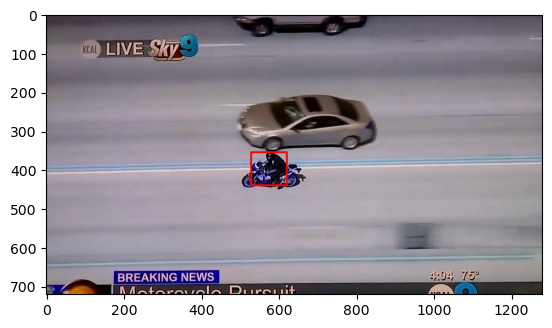

Using last frame
Using last frame
Using last frame
Using last frame
Using last frame


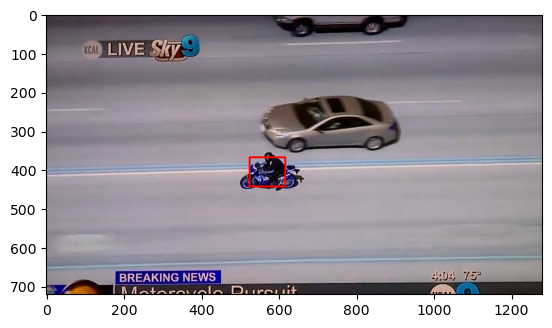

Using last frame


KeyboardInterrupt: 

In [14]:
runTracker()